In [1]:
import latentvelo as ltv
import numpy as np
import scanpy as sc
import scvelo as scv
import cellrank as cr
import matplotlib.pyplot as plt

Global seed set to 0


# Read data from cellrank package

In [2]:
adata = cr.datasets.pancreas()

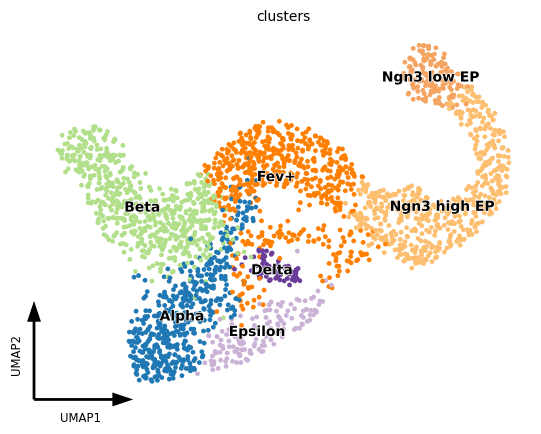

In [3]:
scv.pl.umap(adata, color='clusters', frameon='artist')

# Setup data and train model

In [4]:
scv.pp.filter_genes(adata, min_shared_counts=20)
ltv.utils.anvi_clean_recipe(adata, celltype_key='clusters')

Filtered out 22024 genes that are detected 20 counts (shared).
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:10) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [5]:
model = ltv.models.AnnotVAE(observed=2000, latent_dim=30, encoder_hidden=35, zr_dim=2, h_dim=3, 
                            celltypes=len(adata.obs.clusters.unique()))

In [6]:
epochs, val_ae, val_traj = ltv.train(model, adata, batch_size = 100,
                                      epochs=50, name='pancreas_parameters', grad_clip=100)

Warning, folder already exists. This may overwrite a previous fit.
910 velocity genes used


/usr/local/lib/python3.8/dist-packages/latentvelo-0.1-py3.8.egg/latentvelo/anvi_dataloader.py:18: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


epoch 0, full loss 308.054, val loss 199.435, ae MSE 3.886, traj MSE 1.253, reg loss -2.507
epoch 1, full loss 183.804, val loss 110.678, ae MSE 3.437, traj MSE 1.108, reg loss -2.935
epoch 2, full loss 197.060, val loss 35.052, ae MSE 2.723, traj MSE 1.072, reg loss -3.211
epoch 3, full loss 128.419, val loss -44.054, ae MSE 2.306, traj MSE 0.918, reg loss -3.258
epoch 4, full loss 139.479, val loss -126.588, ae MSE 2.161, traj MSE 0.831, reg loss -3.262
epoch 5, full loss 55.955, val loss -206.124, ae MSE 1.776, traj MSE 0.786, reg loss -3.460
epoch 6, full loss -44.188, val loss -278.601, ae MSE 1.647, traj MSE 0.806, reg loss -3.163
epoch 7, full loss -37.329, val loss -337.866, ae MSE 1.406, traj MSE 0.725, reg loss -2.816
epoch 8, full loss -29.244, val loss -394.931, ae MSE 1.400, traj MSE 0.693, reg loss -2.649
epoch 9, full loss -29.144, val loss -441.498, ae MSE 1.366, traj MSE 0.680, reg loss -2.428
epoch 10, full loss -84.879, val loss -478.327, ae MSE 1.319, traj MSE 0.638

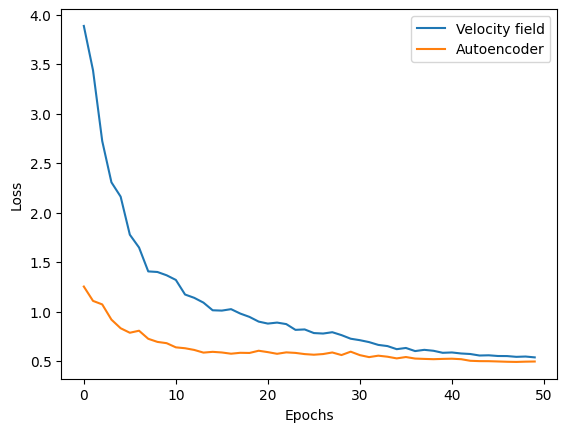

In [7]:
ltv.plot_history(epochs, val_ae, val_traj)
plt.show()

# Compute velocities and plot on UMAP

In [8]:
latent_adata, adata = ltv.output_results(model, adata, gene_velocity=True, decoded=True)

In [9]:
scv.tl.velocity_graph(latent_adata, vkey='spliced_velocity')

computing velocity graph (using 1/16 cores)


  0%|          | 0/2531 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)


/home/spencer/.local/lib/python3.8/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ../figures/pancreas_model_umap.png


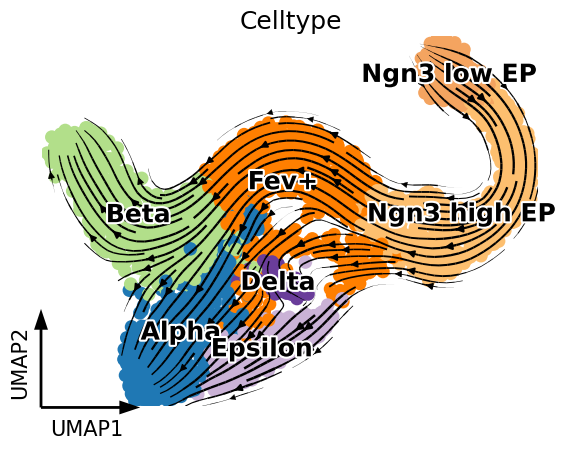

In [10]:
scv.pl.velocity_embedding_stream(latent_adata,vkey='spliced_velocity', color=['clusters'], 
                                 title='Celltype', alpha=1, 
                                 legend_fontsize=18, legend_fontoutline=3, fontsize=18, frameon='artist',
                                save='../figures/pancreas_model_umap.png')

saving figure to file ../figures/pancreas_model_umap_lineages.png


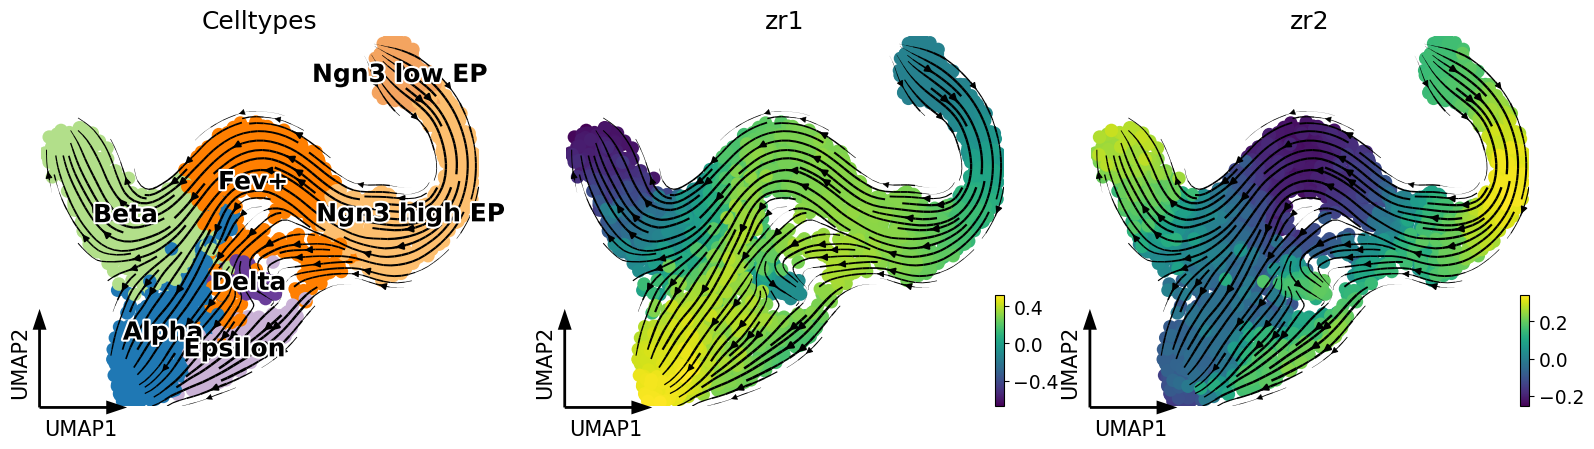

In [11]:
latent_adata.obs['zr1'] = latent_adata.obsm['zr'][:,0]
latent_adata.obs['zr2'] = latent_adata.obsm['zr'][:,1]
scv.pl.velocity_embedding_stream(latent_adata,vkey='spliced_velocity', color=['clusters', 'zr1', 'zr2'], 
                                 title=['Celltypes', 'zr1', 'zr2'], alpha=1, 
                                 legend_fontsize=18, legend_fontoutline=3, fontsize=18, frameon='artist',
                                save='../figures/pancreas_model_umap_lineages.png')

In [12]:
# save fit
latent_adata.write('../benchmark/real_data/fits/pancreas_latent_adata.h5ad')

# Gene velocities

Select a few genes with high test set R2 scores

In [13]:
adata.var.R2_test[['Cpe', 'Nnat', 'Ppp3ca']]

index
Cpe       0.656812
Nnat      0.903472
Ppp3ca    0.851827
Name: R2_test, dtype: float64

Show gene spliced vs unspliced gene dynamics

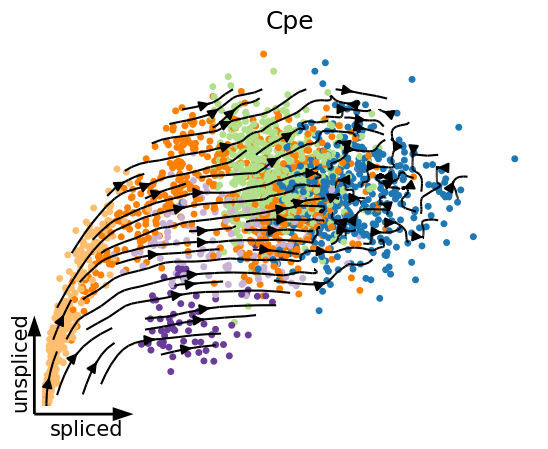

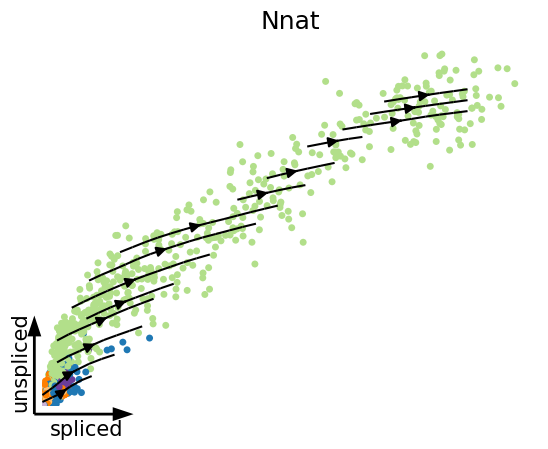

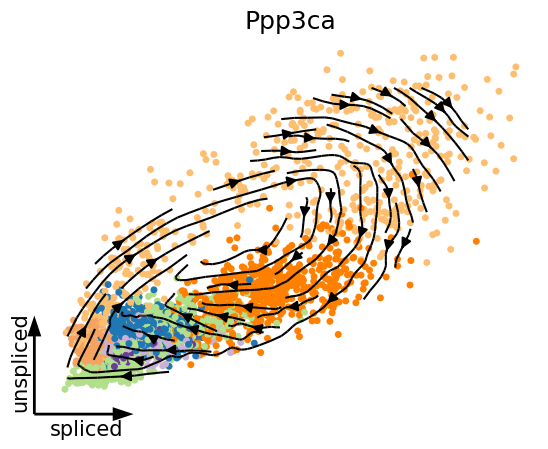

In [14]:
ltv.pl.scatter_stream(adata, 'Cpe', cluster_key='clusters')#,save=True)#
plt.show()
ltv.pl.scatter_stream(adata, 'Nnat', cluster_key='clusters', min_density=0.5)
plt.show()
ltv.pl.scatter_stream(adata, 'Ppp3ca', cluster_key='clusters')#,save=True)#
plt.show()

Show value of velocity and latent time vs spliced.

saving figure to file ../figures/Nnat_direction.png


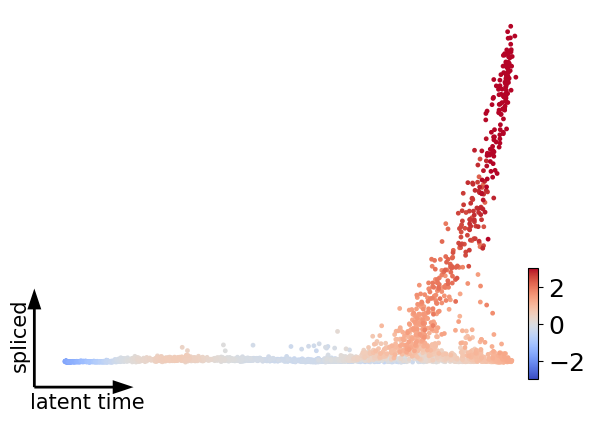

saving figure to file ../figures/Cpe_direction.png


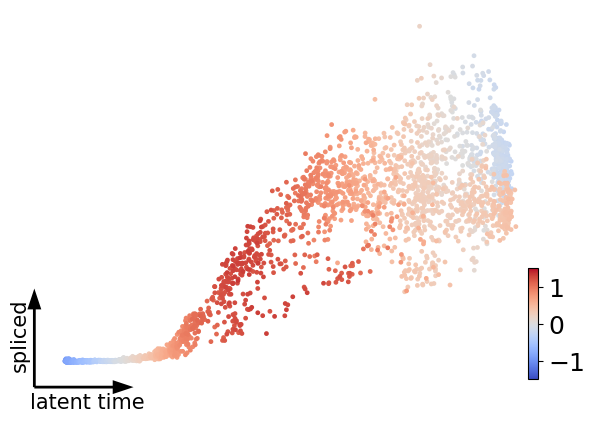

saving figure to file ../figures/Ppp3ca_direction.png


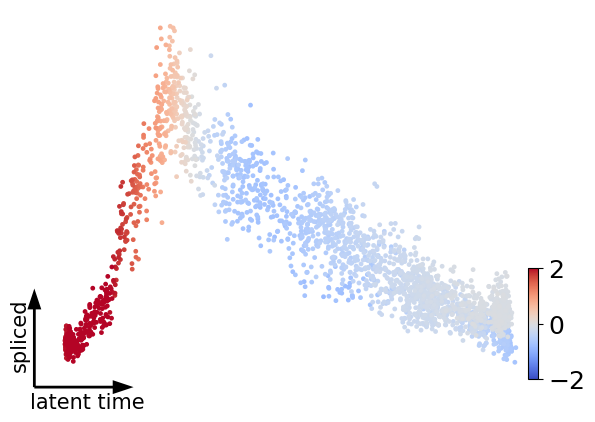

In [15]:
adata.obs['Cpe_direction'] = adata[:,adata.var.index.values=='Cpe'].layers['velo'][:,0] # > 0
adata.obs['Ppp3ca_direction'] = adata[:,adata.var.index.values=='Ppp3ca'].layers['velo'][:,0] # > 0
adata.obs['Nnat_direction'] = adata[:,adata.var.index.values=='Nnat'].layers['velo'][:,0] # > 0
adata.obs['Smoc1_direction'] = adata[:,adata.var.index.values=='Smoc1'].layers['velo'][:,0] # > 0

scv.pl.scatter(adata, x='latent_time', y='Nnat', color='Nnat_direction', color_map='coolwarm',
              title='', vmin=-3, vmax=3, frameon='artist', save='../figures/Nnat_direction.png')

scv.pl.scatter(adata, x='latent_time', y='Cpe', color='Cpe_direction', color_map='coolwarm', 
               title='', vmin=-1.5, vmax=1.5, frameon='artist', save='../figures/Cpe_direction.png')

scv.pl.scatter(adata, x='latent_time', y='Ppp3ca', color='Ppp3ca_direction', color_map='coolwarm',
               title='', vmin=-2, vmax=2, frameon='artist', save='../figures/Ppp3ca_direction.png')

# Compute CBDir transition scores

In [16]:
pancreas_edges = [
    ('Ngn3 low EP', 'Ngn3 high EP'), 
    ('Ngn3 high EP', 'Fev+'),
    ('Fev+', 'Delta'), 
    ('Fev+', 'Beta'), ('Fev+','Epsilon'), ('Fev+','Alpha')]

In [17]:
scv.tl.velocity_embedding(latent_adata, vkey='spliced_velocity', basis='pca')
pancreas_pca = ltv.ev.cross_boundary_correctness(latent_adata,
                                  'clusters', 'spliced_velocity_pca', pancreas_edges, x_emb='X_pca', 
                                                  majority_vote=True, return_raw=True)

computing velocity embedding
    finished (0:00:01) --> added
    'spliced_velocity_pca', embedded velocity vectors (adata.obsm)


/home/spencer/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


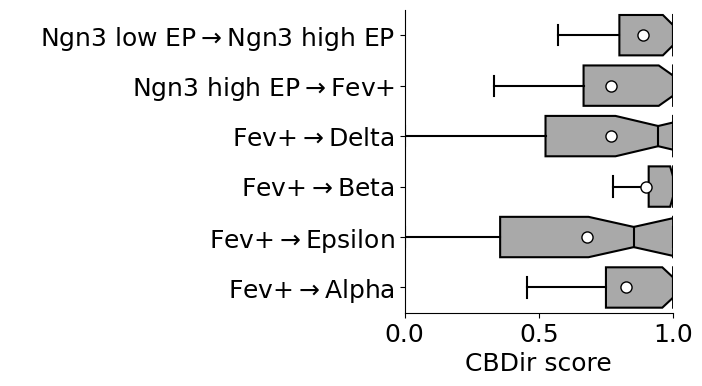

In [18]:
ax=ltv.pl.transition_scores(pancreas_pca, raw=True)
ax.set(xlim=(0,1))
plt.savefig('../figures/pancreas_transitions.pdf')
plt.show()

# Plot z_r scatter and compute lineage classification accuracy from z_r

Renamed 'zr' to convention 'X_zr' (adata.obsm).
saving figure to file ../figures/pancreas_zr_plot.png


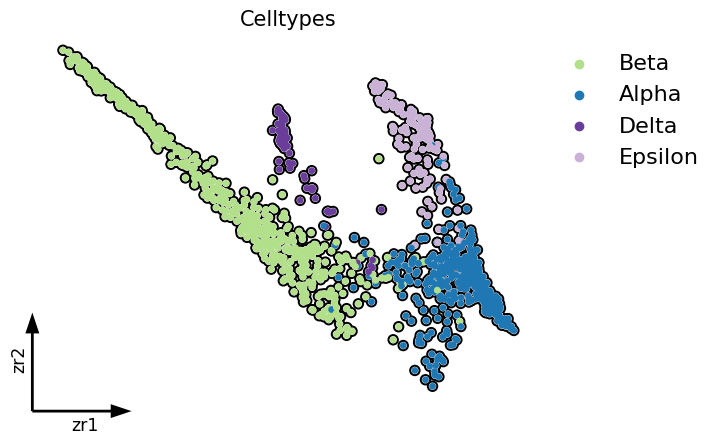

In [19]:
scv.pl.scatter(latent_adata[latent_adata.obs.clusters.isin(['Alpha', 'Beta', 'Delta', 'Epsilon'])],
               'zr', color='clusters', frameon='artist', title='Celltypes', fontsize=15,
              legend_fontsize=16, add_outline=True, save='../figures/pancreas_zr_plot.png')

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier() #LogisticRegression(penalty='none', max_iter=1e4)

data_= latent_adata[latent_adata.obs['clusters'].isin(['Epsilon', 'Alpha', 'Beta', 'Delta'])].copy()


X = data_.obsm['zr']
y = LabelEncoder().fit_transform(data_.obs['clusters'].values)


pancreas_cvs = cross_val_score(clf, X, y, cv=25)

In [21]:
print('Prediction accuracy (2.5, 50, 97.5) percentiles:', np.percentile(pancreas_cvs, q=[2.5,50,97.5]))

Prediction accuracy (2.5, 50, 97.5) percentiles: [0.92156863 0.96078431 1.        ]


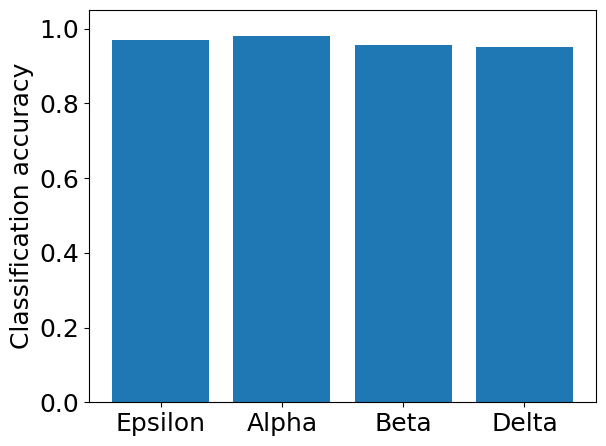

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
clf.fit(X, y)
pred = clf.predict(X)
class_accuracy = confusion_matrix(y, pred, normalize="true").diagonal()

fig, ax = plt.subplots()

plt.bar(x=['Epsilon', 'Alpha', 'Beta', 'Delta'],height=class_accuracy)

ax.set(ylim=(0,1.05))
ax.set(ylabel='Classification accuracy')
plt.tight_layout()
plt.show()

In [23]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
label_encoder = LabelEncoder()
celltype = label_encoder.fit_transform(latent_adata.obs['clusters'])
latent_adata.obs['celltype_id'] = celltype

In [24]:
colors = []
for i in range(latent_adata[latent_adata.obs.clusters.isin(['Alpha', 'Beta', 'Delta', 'Epsilon'])].shape[0]):
    if latent_adata[latent_adata.obs.clusters.isin(['Alpha', 'Beta', 'Delta', 'Epsilon'])].obs.clusters[i] == 'Beta':
        colors.append('#b2df8a')
    elif latent_adata[latent_adata.obs.clusters.isin(['Alpha', 'Beta', 'Delta', 'Epsilon'])].obs.clusters[i] == 'Alpha':
        colors.append('#1f78b4')
    elif latent_adata[latent_adata.obs.clusters.isin(['Alpha', 'Beta', 'Delta', 'Epsilon'])].obs['clusters'][i] == 'Delta':
        colors.append('#6a3d9a')
    else:
        colors.append('#cab2d6')

(1277, 2)


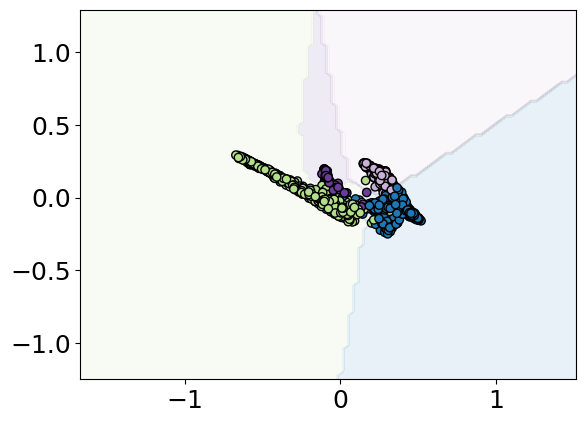

In [25]:
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=50)

data_= latent_adata[latent_adata.obs['clusters'].isin(['Epsilon', 'Alpha', 'Beta', 'Delta'])].copy()


X = data_.obsm['zr']
print(X.shape) 
y = LabelEncoder().fit_transform(data_.obs['clusters'].values)


clf.fit(X, y)

import matplotlib.colors
cmap = matplotlib.colors.ListedColormap(['#1f78b4', '#b2df8a', '#6a3d9a', '#cab2d6'])

disp = DecisionBoundaryDisplay.from_estimator(
clf, X, response_method="predict", cmap=cmap,
alpha=0.1,
)
disp.ax_.scatter(X[:, 0], X[:, 1], edgecolor="k", 
                c = colors)
plt.show()

# Latent trajectories

In [26]:
z_traj, times = ltv.cell_trajectories(model, adata, time_steps=100)

Compute UMAP on latent space

In [27]:
from umap import UMAP
from sklearn.preprocessing import LabelEncoder
umap = UMAP(n_components=2, min_dist=1, random_state=12).fit(latent_adata.X)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 1/16 cores)


  0%|          | 0/2531 [00:00<?, ?cells/s]

/home/spencer/.local/lib/python3.8/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:00) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_umap_latent', embedded velocity vectors (adata.obsm)


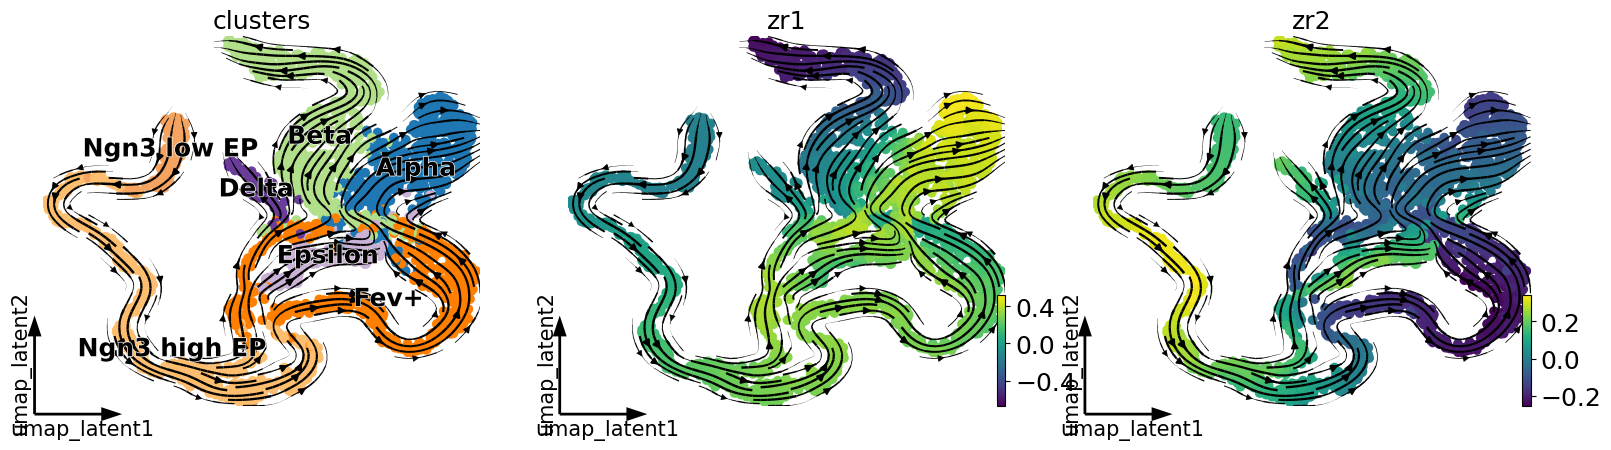

In [28]:
latent_adata.obsm['X_umap_latent'] = umap.transform(latent_adata.X)
latent_adata.obs['zr1'] = latent_adata.obsm['zr'][:,0]
latent_adata.obs['zr2'] = latent_adata.obsm['zr'][:,1]
scv.pp.neighbors(latent_adata, use_rep='X', n_neighbors=30)
scv.tl.velocity_graph(latent_adata, vkey='spliced_velocity')
scv.pl.velocity_embedding_stream(latent_adata, vkey='spliced_velocity', 
                                 basis='umap_latent', color=['clusters','zr1', 'zr2'], alpha=1, size=200,
                                frameon='artist', cutoff_perc=0)

Renamed 'zr' to convention 'X_zr' (adata.obsm).
Renamed 'zr' to convention 'X_zr' (adata.obsm).
Renamed 'zr' to convention 'X_zr' (adata.obsm).
Renamed 'zr' to convention 'X_zr' (adata.obsm).


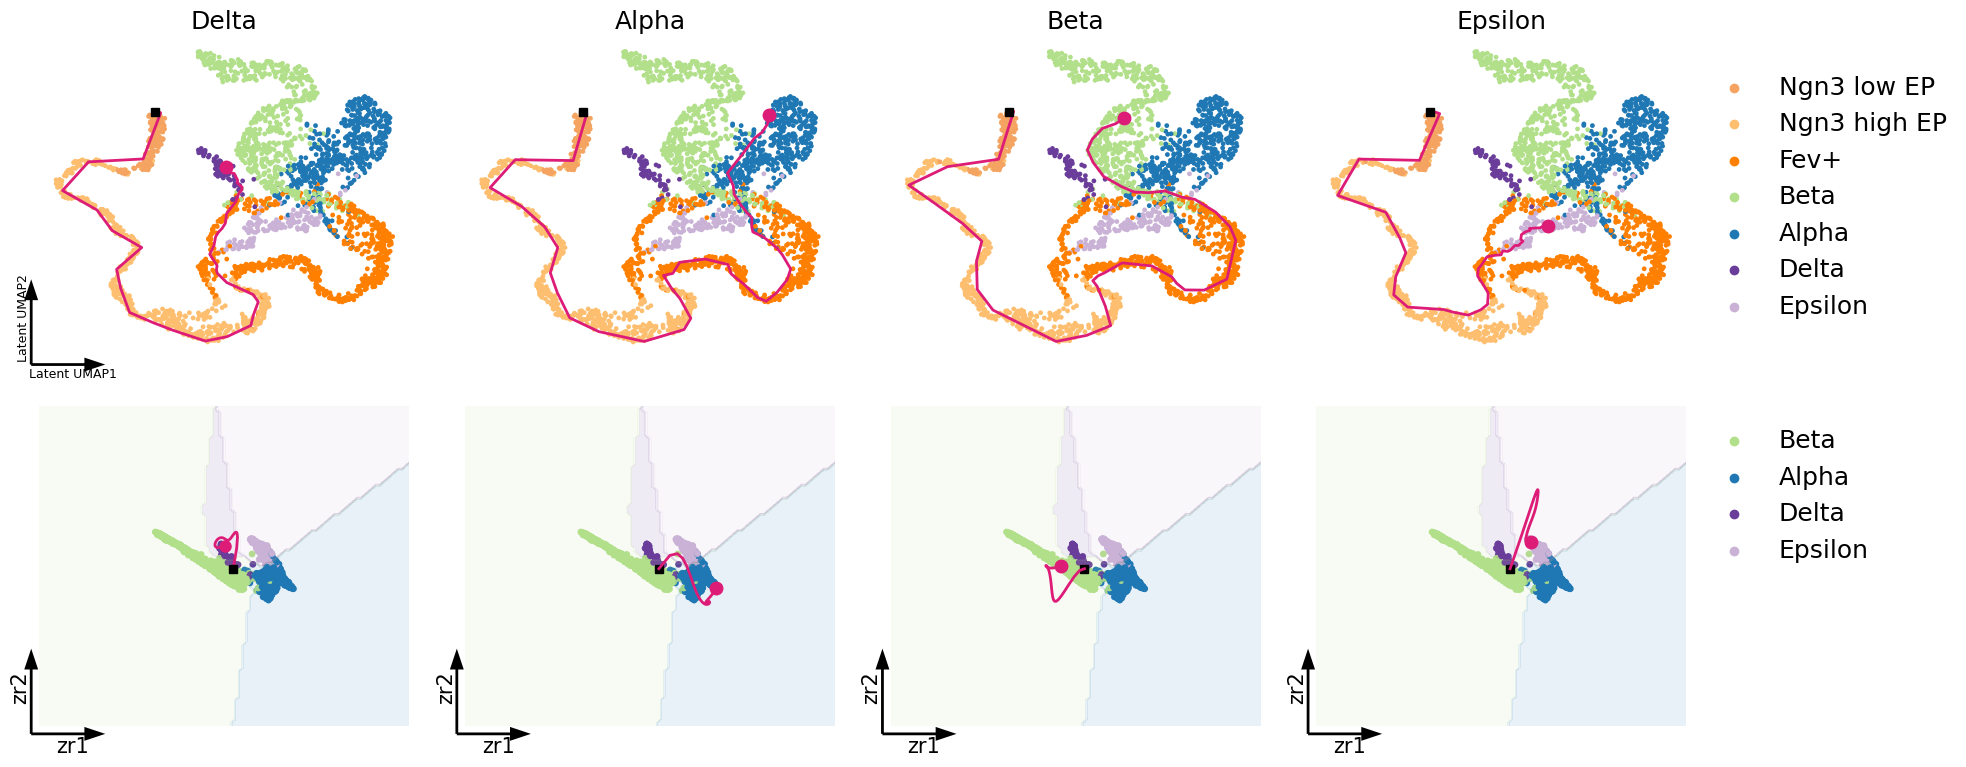

In [29]:
cells = [4, 1833, 52, 229]

from sklearn.inspection import DecisionBoundaryDisplay
color = '#dd1c77'

import matplotlib.colors
cmap = matplotlib.colors.ListedColormap(['#1f78b4', '#b2df8a', '#6a3d9a', '#cab2d6'])


fig,ax=plt.subplots(2, 4, figsize=(20,8))
ax=ax.flatten()


color = '#dd1c77'

latent_adata.obsm['X_umap'] = latent_adata.obsm['X_umap_latent']

z_traj_pca = umap.transform(z_traj[cells[0],times[cells[0],:,0]<=latent_adata.obs['latent_time'][cells[0]],:30].detach().cpu().numpy())
ax[0].plot(z_traj_pca[:,0], z_traj_pca[:,1], color=color, linewidth=2)
ax[0].plot([z_traj_pca[-1,0]], [z_traj_pca[-1,1]], color=color, linewidth=2, marker='o', markersize=9)
ax[0].plot([z_traj_pca[0,0]], [z_traj_pca[0,1]], color='k', linewidth=2, marker='s', markersize=6)

scv.pl.umap(latent_adata, ax=ax[0], color='clusters', frameon='artist',
           xlabel='Latent UMAP1', ylabel='Latent UMAP2', show=False, title='Delta',
           legend_loc='none')
#ax[0].titlesize(12)
ax[0].xaxis.label.set_size(9)
ax[0].yaxis.label.set_size(9)


z_traj_pca = umap.transform(z_traj[cells[1],times[cells[1],:,0]<=latent_adata.obs['latent_time'][cells[1]],:30].detach().cpu().numpy())
ax[1].plot(z_traj_pca[:,0], z_traj_pca[:,1], color=color, linewidth=2)
ax[1].plot([z_traj_pca[-1,0]], [z_traj_pca[-1,1]], color=color, linewidth=2, marker='o', markersize=9)
ax[1].plot([z_traj_pca[0,0]], [z_traj_pca[0,1]], color='k', linewidth=2, marker='s', markersize=6)

scv.pl.umap(latent_adata, ax=ax[1], color='clusters',
           xlabel='Latent UMAP1', ylabel='Latent UMAP2', show=False, title='Alpha',
           legend_loc='none')


z_traj_pca = umap.transform(z_traj[cells[2],times[cells[2],:,0]<=latent_adata.obs['latent_time'][cells[2]],:30].detach().cpu().numpy())
ax[2].plot(z_traj_pca[:,0], z_traj_pca[:,1], color=color, linewidth=2)
ax[2].plot([z_traj_pca[-1,0]], [z_traj_pca[-1,1]], color=color, linewidth=2, marker='o', markersize=9)
ax[2].plot([z_traj_pca[0,0]], [z_traj_pca[0,1]], color='k', linewidth=2, marker='s', markersize=6)

scv.pl.umap(latent_adata, ax=ax[2], color='clusters',
           xlabel='Latent UMAP1', ylabel='Latent UMAP2', show=False, title='Beta',
           legend_loc='none')


z_traj_pca = umap.transform(z_traj[cells[3],times[cells[3],:,0]<=latent_adata.obs['latent_time'][cells[3]],:30].detach().cpu().numpy())
ax[3].plot(z_traj_pca[:,0], z_traj_pca[:,1], color=color, linewidth=2)
ax[3].plot([z_traj_pca[-1,0]], [z_traj_pca[-1,1]], color=color, linewidth=2, marker='o', markersize=9)
ax[3].plot([z_traj_pca[0,0]], [z_traj_pca[0,1]], color='k', linewidth=2, marker='s', markersize=6)

scv.pl.umap(latent_adata, ax=ax[3], color='clusters',
           xlabel='Latent UMAP1', ylabel='Latent UMAP2', show=False, title='Epsilon',
           legend_loc='right')






disp = DecisionBoundaryDisplay.from_estimator(
clf, X, response_method="predict", cmap=cmap,
alpha=0.1,ax=ax[4]
)
disp = DecisionBoundaryDisplay.from_estimator(
clf, X, response_method="predict", cmap=cmap,
alpha=0.1,ax=ax[5]
)
disp = DecisionBoundaryDisplay.from_estimator(
clf, X, response_method="predict", cmap=cmap,
alpha=0.1,ax=ax[6]
)
disp = DecisionBoundaryDisplay.from_estimator(
clf, X, response_method="predict", cmap=cmap,
alpha=0.1,ax=ax[7]
)
    

z_traj_pca = (z_traj[cells[0],times[cells[0],:,0]<=latent_adata.obs['latent_time'][cells[0]],60:].detach().cpu().numpy())
ax[4].plot(z_traj_pca[:,0], z_traj_pca[:,1], color=color, linewidth=2)
ax[4].plot([z_traj_pca[-1,0]], [z_traj_pca[-1,1]], color=color, linewidth=2, marker='o', markersize=8)

for i in range(4,4+4):
    ax[i].plot([z_traj_pca[0,0]], [z_traj_pca[0,1]], color='k', linewidth=2, marker='s', markersize=6)


scv.pl.scatter(latent_adata[latent_adata.obs['clusters'].isin(['Alpha', 'Beta', 'Epsilon', 'Delta'])], 
               'zr', ax=ax[4], 
               color='clusters', frameon='artist',
           xlabel='zr1', ylabel='zr2', fontsize=18, title='', show=False,
              legend_loc='none')

z_traj_pca = (z_traj[cells[1],times[cells[1],:,0]<=latent_adata.obs['latent_time'][cells[1]],60:].detach().cpu().numpy())
ax[5].plot(z_traj_pca[:,0], z_traj_pca[:,1], color=color, linewidth=2)
ax[5].plot([z_traj_pca[-1,0]], [z_traj_pca[-1,1]], color=color, linewidth=2, marker='o', markersize=9)

scv.pl.scatter(latent_adata[latent_adata.obs['clusters'].isin(['Alpha', 'Beta', 'Epsilon', 'Delta'])], 
               'zr', ax=ax[5], 
               color='clusters', frameon='artist',
           xlabel='zr1', ylabel='zr2', fontsize=18, title='', show=False,
              legend_loc='none')

z_traj_pca = (z_traj[cells[2],times[cells[2],:,0]<=latent_adata.obs['latent_time'][cells[2]],60:].detach().cpu().numpy())
ax[6].plot(z_traj_pca[:,0], z_traj_pca[:,1], color=color, linewidth=2)
ax[6].plot([z_traj_pca[-1,0]], [z_traj_pca[-1,1]], color=color, linewidth=2, marker='o', markersize=9)

scv.pl.scatter(latent_adata[latent_adata.obs['clusters'].isin(['Alpha', 'Beta', 'Epsilon', 'Delta'])], 
               'zr', ax=ax[6], 
               color='clusters', frameon='artist',
           xlabel='zr1', ylabel='zr2', fontsize=18, title='', show=False,
              legend_loc='none')

z_traj_pca = (z_traj[cells[3],times[cells[3],:,0]<=latent_adata.obs['latent_time'][cells[3]],60:].detach().cpu().numpy())
ax[7].plot(z_traj_pca[:,0], z_traj_pca[:,1], color=color, linewidth=2)
ax[7].plot([z_traj_pca[-1,0]], [z_traj_pca[-1,1]], color=color, linewidth=2, marker='o', markersize=9)

scv.pl.scatter(latent_adata[latent_adata.obs['clusters'].isin(['Alpha', 'Beta', 'Epsilon', 'Delta'])],
               'zr', ax=ax[7], 
               color='clusters', frameon='artist',legend_fontsize=18,
           xlabel='zr1', ylabel='zr2', fontsize=18, title='', show=False)
plt.tight_layout()
plt.savefig('../figures/pancreas_both_dynamics.png', dpi=500)
plt.show()

In [30]:
clusters = np.array(['Ngn3 low EP', 'Ngn3 high EP', 'Fev+', 'Beta', 'Alpha', 'Delta', 'Epsilon'])
colors = latent_adata.uns['clusters_colors']

cell_color = []
for i in range(latent_adata.shape[0]):
    cell_color.append(colors[np.where(clusters == latent_adata.obs.clusters[i])[0][0]])


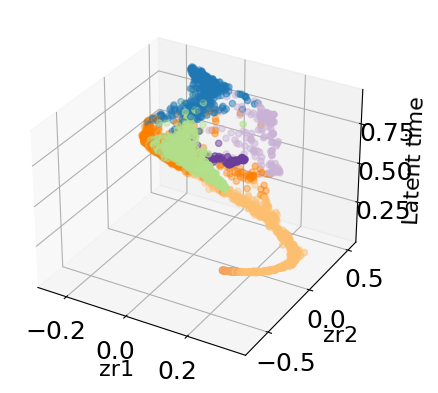

In [31]:
#%matplotlib notebook
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')


# Data for a three-dimensional line
xdata = latent_adata.obs.latent_time
ydata = latent_adata.obsm['zr'][:,0]
zdata = latent_adata.obsm['zr'][:,1]


ax.scatter3D(zdata, ydata, xdata, color = cell_color);

ax.set_zlabel('Latent time',fontsize=16)
ax.set_ylabel('zr2',fontsize=16)
ax.set_xlabel('zr1',fontsize=16)

#ax.

plt.draw()
plt.show()

In [32]:
plt.tight_layout()
plt.savefig('figures/3d_plot.pdf')